# SAXS&WAXS pipeline for calibrations of beamline parameters, including beam center, det-sam distance etc.


## Overview

* Setup: load packages/setup path
* Load Mask (made at the beamline)
* Check beam center
* Do circulare average to check the det-sam distance
* Export calibration results (mask data, beamline parameters) to a hdf file 
 

### DEV
* V0: Initialize the pipeline (2019/10/26 by YG yuzhang@bnl.gov)
* V1: Develop the pyScatt package (2019/11/6 by YG yuzhang@bnl.gov 
* V2: Develop make mask and check beam center using a qphi-analysis 
<br> $\;\;\;\;$   Develop the create mask option to make circle, rotated_line shapes 
<br> $\;\;\;\;$   Develop the qphi analysis to check the beam center
* V3: Develop automatically search beam center
* V4: Add more controls/functions for the creation of mask
* V5: use pyFAI detector class for create mask
* V7: Develop a second versio for automatically search beam center

## TODLIST
* 



In [1]:
%matplotlib notebook
from pyScatt.packages import *
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })

plt.rcParams.update({ 'image.interpolation': 'none'   })
 

# WAXS--Setup paths

In [2]:
####
#username = 'yuzhang'
#inDir = '/home/%s/Test_SAXS/Data/'%username
#outDir = '/home/%s/Test_SAXS/Results/'%username

inDir = '/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/waxs/raw/'
outDir = '/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/'


create_fullpath(  outDir )

Directory  /home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/  already exists


'/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/'

## check one data

In [3]:
fp = 'AgBH_cali_3m_13.5kev_x0.000_y0.000_5.00s_273001_waxs.tiff'
#fp = 'FL_Mar19_CB_313_202.6s_x0.400_y-0.000_10.00s_272994_waxs.tiff'
#fp = 'FL_Mar19_ZMIM_246.4s_x0.400_y0.000_1.00s_272995_waxs.tiff'

img = get_cms_img( fp, inDir ) #[::-1]

<IPython.core.display.Javascript object>


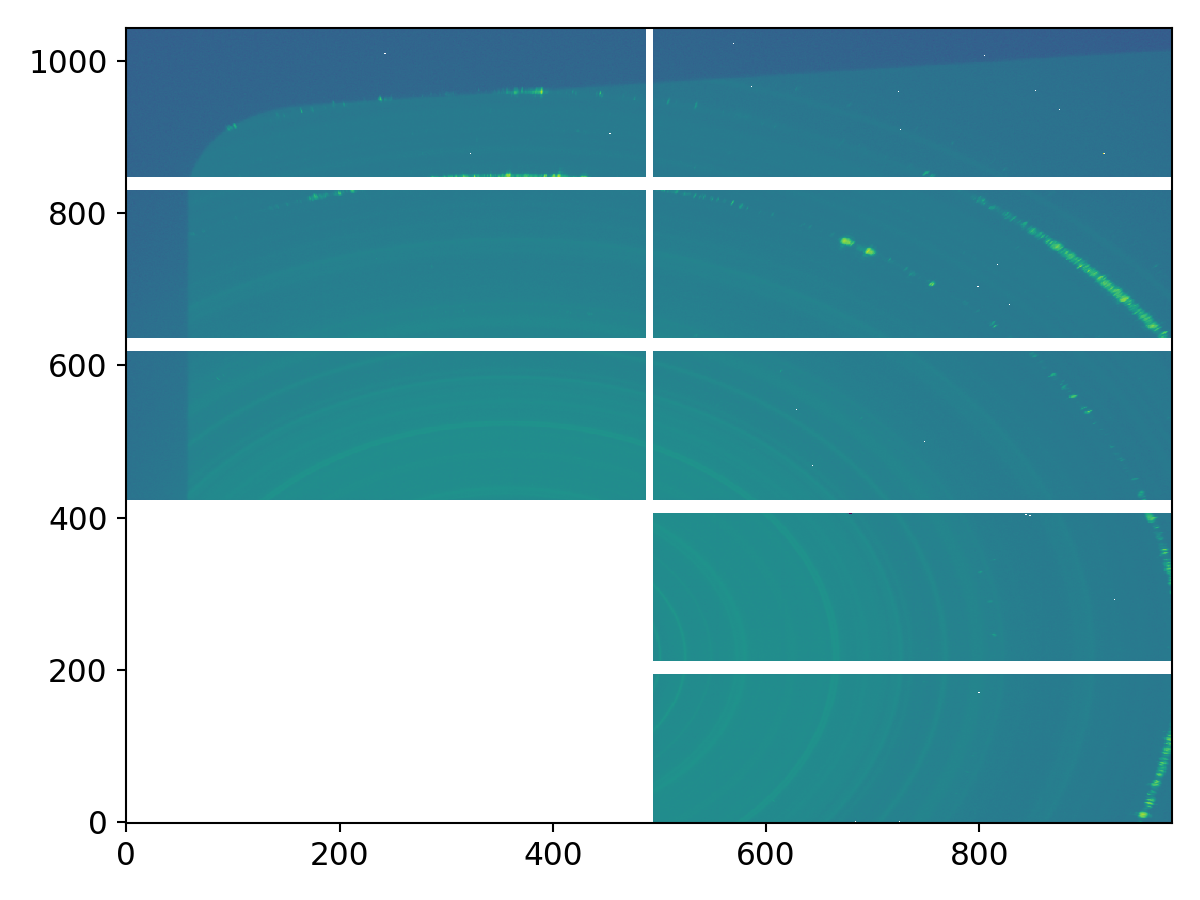

In [4]:
show_img( img , logs=True)

## create mask

In [5]:
%run -i /home/yuzhang/Software/pyScatt/pyScatt/Detectors.py

## get the chip mask

In [6]:
det = get_detector( 'Pilatus800' )
maskw = det.calc_mask()[::-1]

<IPython.core.display.Javascript object>


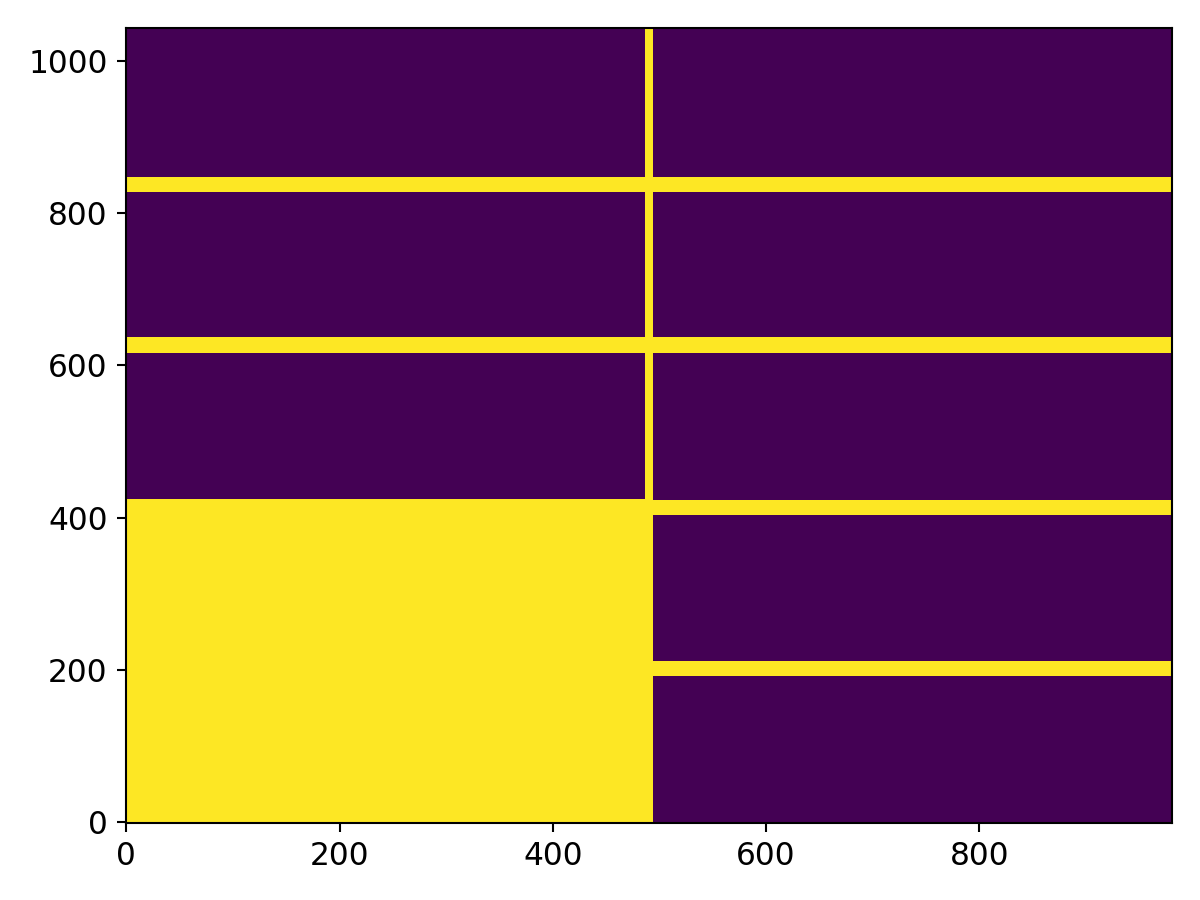

In [7]:
show_img( maskw )

## creaete the custom mask

In [8]:
maskwc= np.ones_like( maskw)

maskwc[  : ,: 75  ] = False
maskwc[   950:  ,  :    ] = False
maskwc[   870:960 , 70 : 150    ] = False
maskwc[   930:960 ,  150:350    ] = False
 
maskwc = np.logical_not( maskwc )
maskw += (maskwc    )


<IPython.core.display.Javascript object>


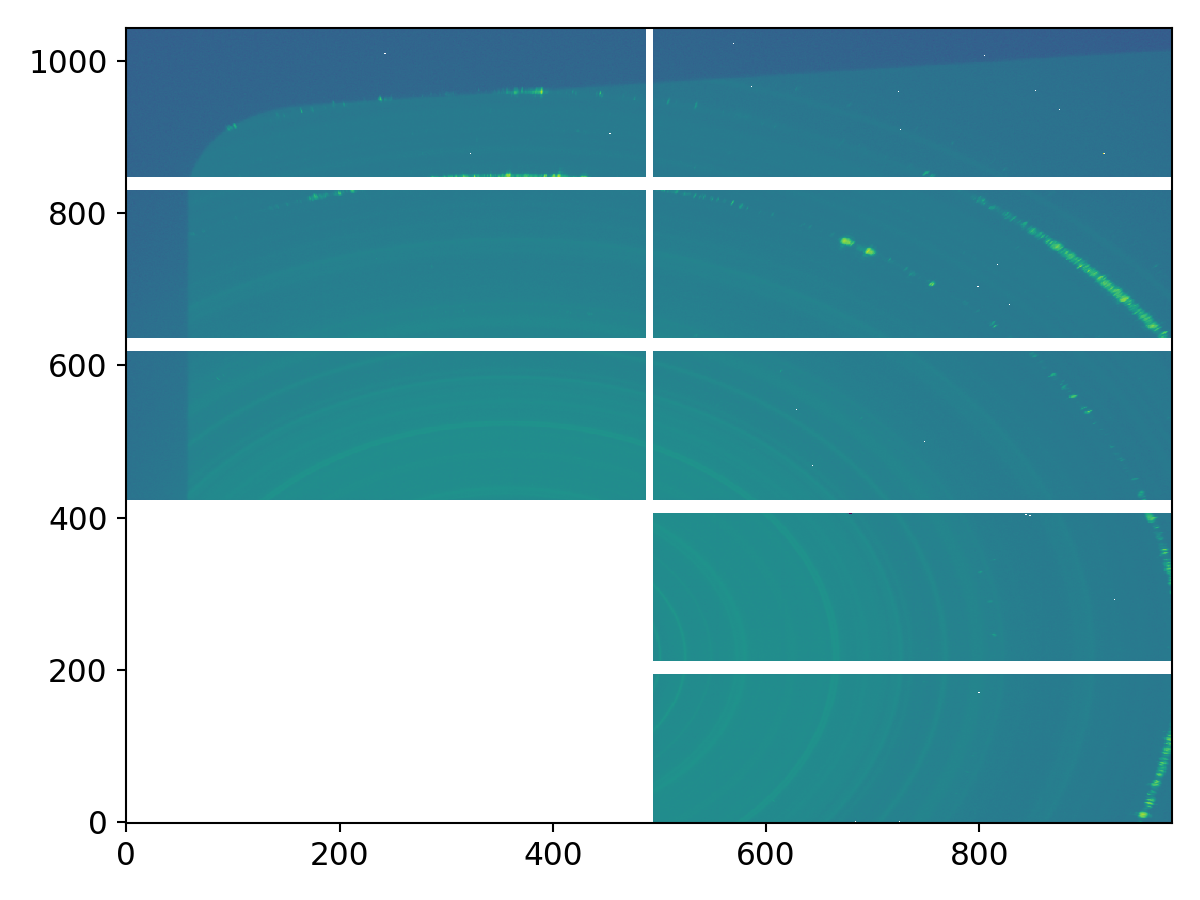

In [9]:
show_img( img , logs=True)

<IPython.core.display.Javascript object>


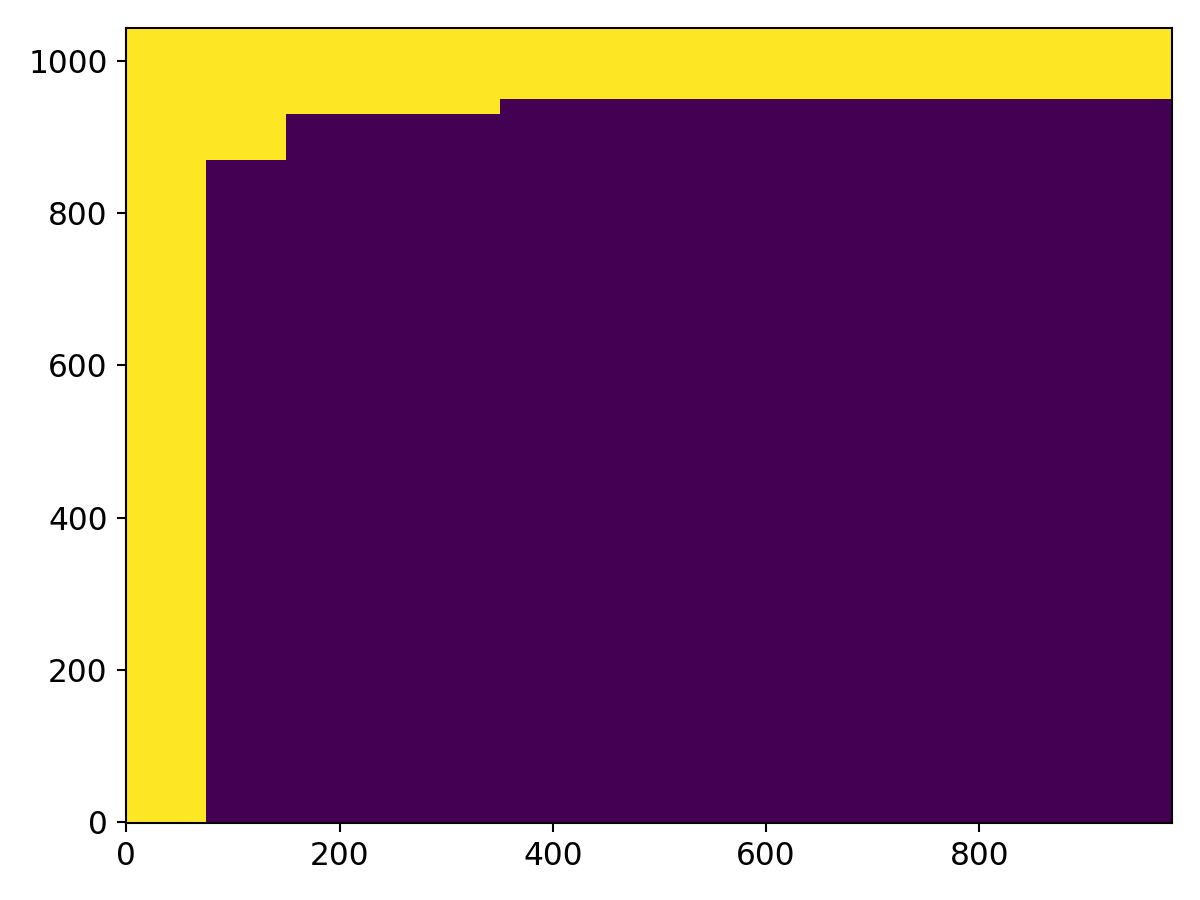

In [10]:
show_img(  maskwc )

1089242


<IPython.core.display.Javascript object>


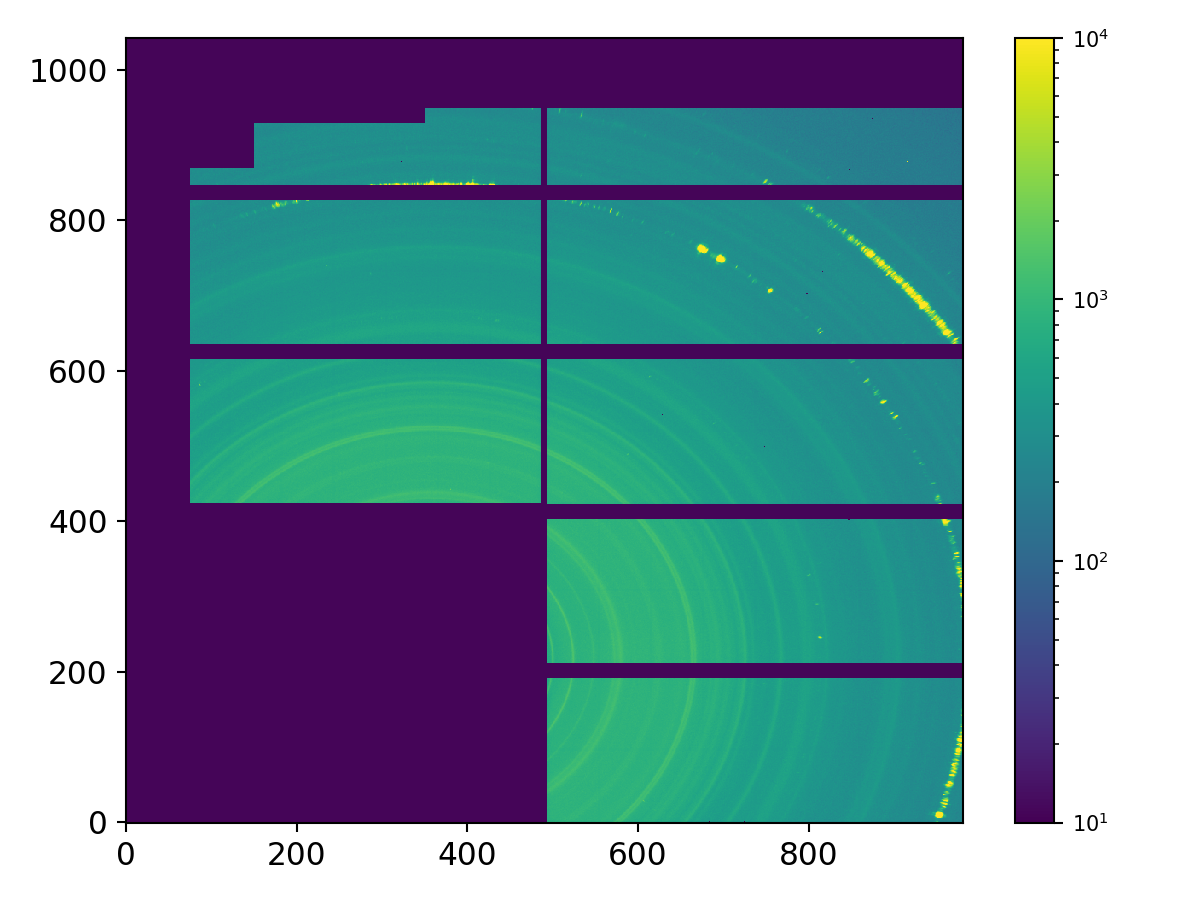

In [11]:
img_  = img * ~maskw
print(img_.max())
mth = img_>1e6

maskw += mth


show_img( img_, logs=True, show_colorbar=True, vmax=1e4, vmin=10 )

## Check Beam center and distance

In [12]:
username = 'Test'
beamline = 'CMS'
cycle='XX'
#geometry   =  'Reflection'
geometry   = 'Transmission'
wav_m = 1E-10 * (12.398/13.5)

sdd_mm =  260.8 #257  #260.8 
b_xy = [  359, 218  ]

bs_xy = [ 0.0, 0.0]   
incident_angle = 0
det_str = 'Pilatus800'
hotpixel_thres = 1e6  
pargs_sc = dict( wav_m = wav_m, 
                sdd_mm = sdd_mm, 
                b_xy =b_xy, 
                bs_xy = bs_xy, 
                incident_angle = incident_angle,             
                det_str = det_str, 
                bs_kind = None, 
                useqx = True,
                geometry =  geometry,                
                username = username, 
                cycle =  cycle, 
                beamline = beamline, 
                outDir = outDir, )
              # mask = mask )    
## Setup the class
SC = CMS_Scattering( pargs_sc  )

## Using Ring to roughly check beamcenter

In [13]:

r1 = 626


r2=r1 + 1
ring = create_ring_mask( img.shape,  r1 = r1 , r2= r2, center= b_xy)
Img = (img * ~maskw).copy()
#Img[ring] = 3000
#plot1D( Img [~maskw*ring], c='k', m='o')

<IPython.core.display.Javascript object>


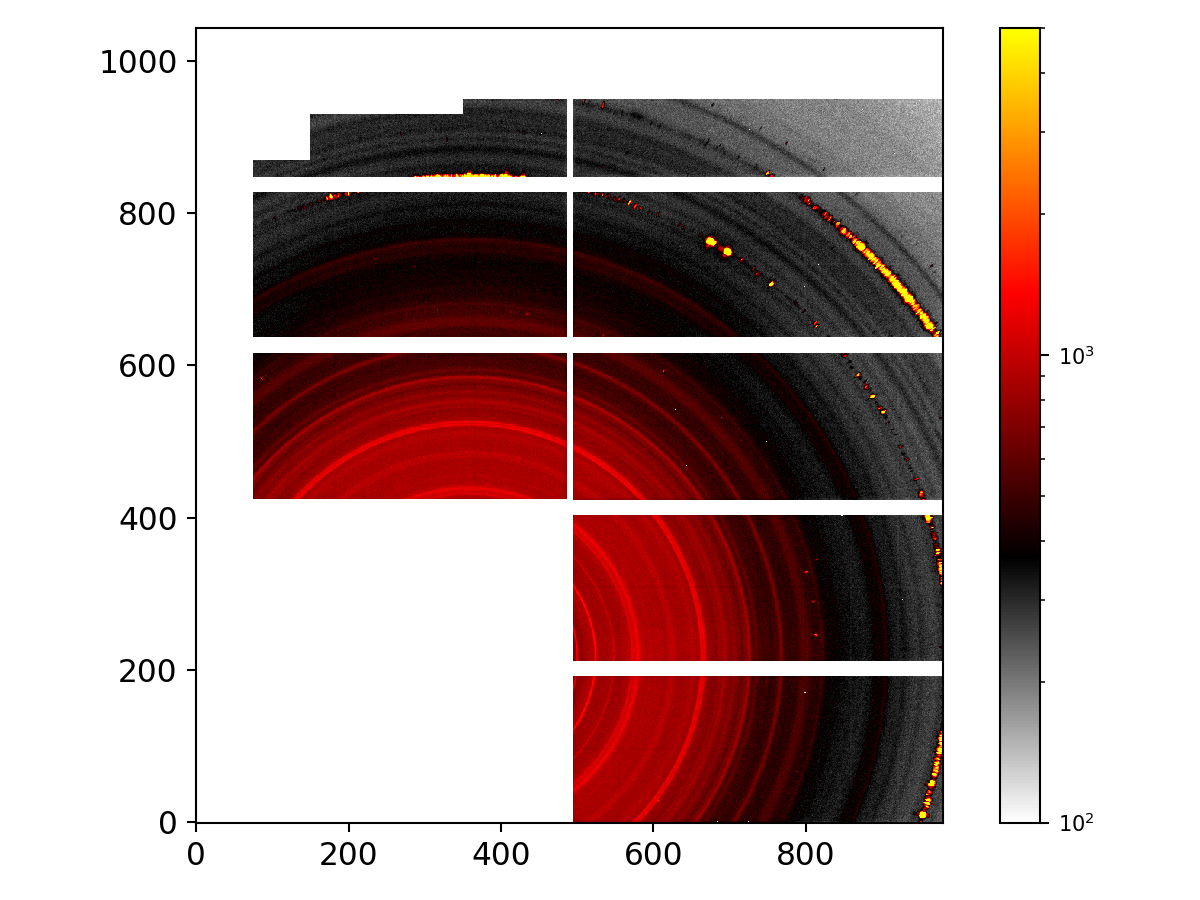

In [14]:


show_img( Img, logs=True, show_colorbar=True, vmax=5e3, vmin=100, aspect=1,cmap=cmap_albula, )
       # xlim=[0,800],ylim=[500,1043] )
    
    

<IPython.core.display.Javascript object>


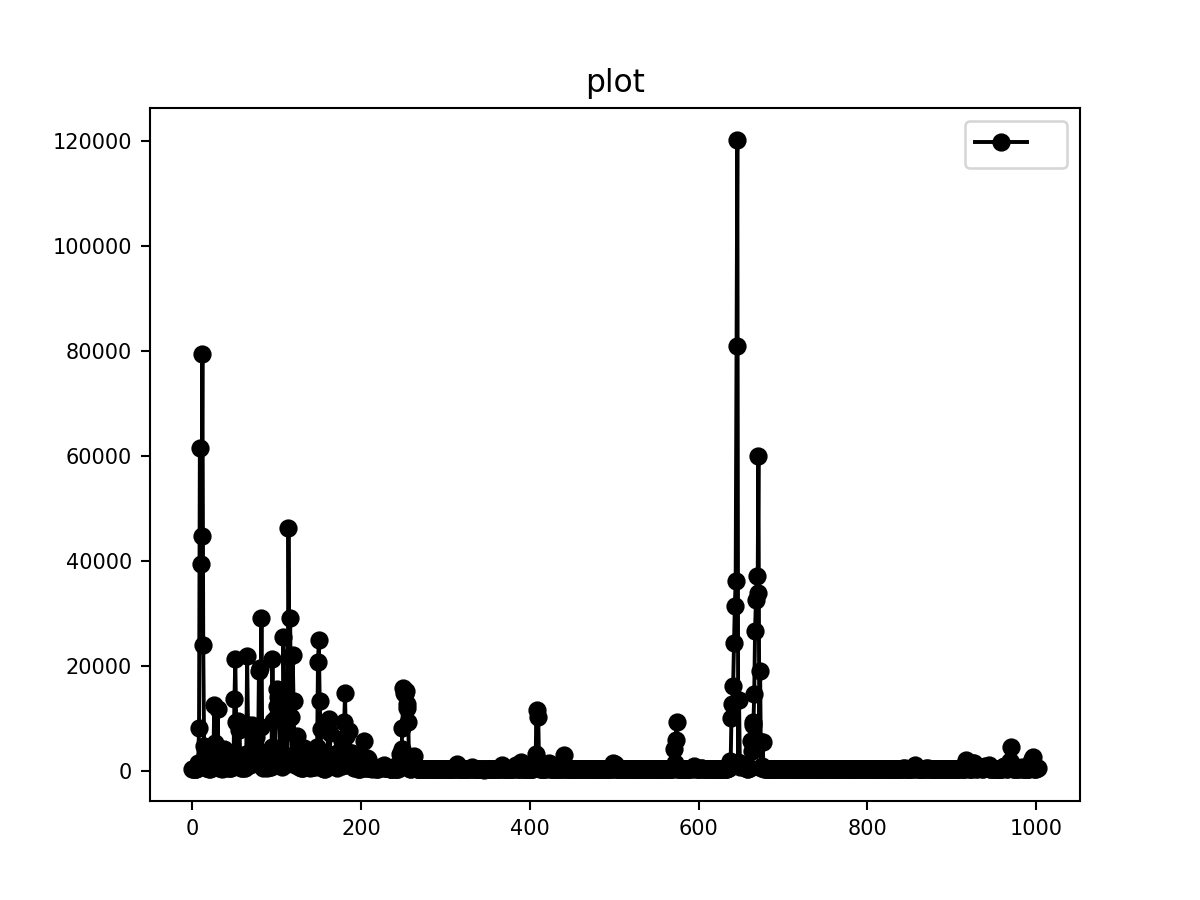

In [15]:
plot1D( Img [~maskw*ring], c='k', m='o')

In [16]:
#show_img(maskw)

In [17]:
q_ca,iq_ca = SC.img_circular_average(img= Img,Qrange=None,Prange=None,
                                                     bins=1500,method='ai',mask=maskw)



In [18]:
la = 4.0782  #4.03 #4.0782 #4.065  
d111 = la / np.sqrt(3)
d200 = la / 2

p111 = 2*np.pi/d111
p200 = 2*np.pi/d200

p100 = 2*np.pi/58.3803  #for AgBH 
print(p100)

0.10762509454695482


<IPython.core.display.Javascript object>


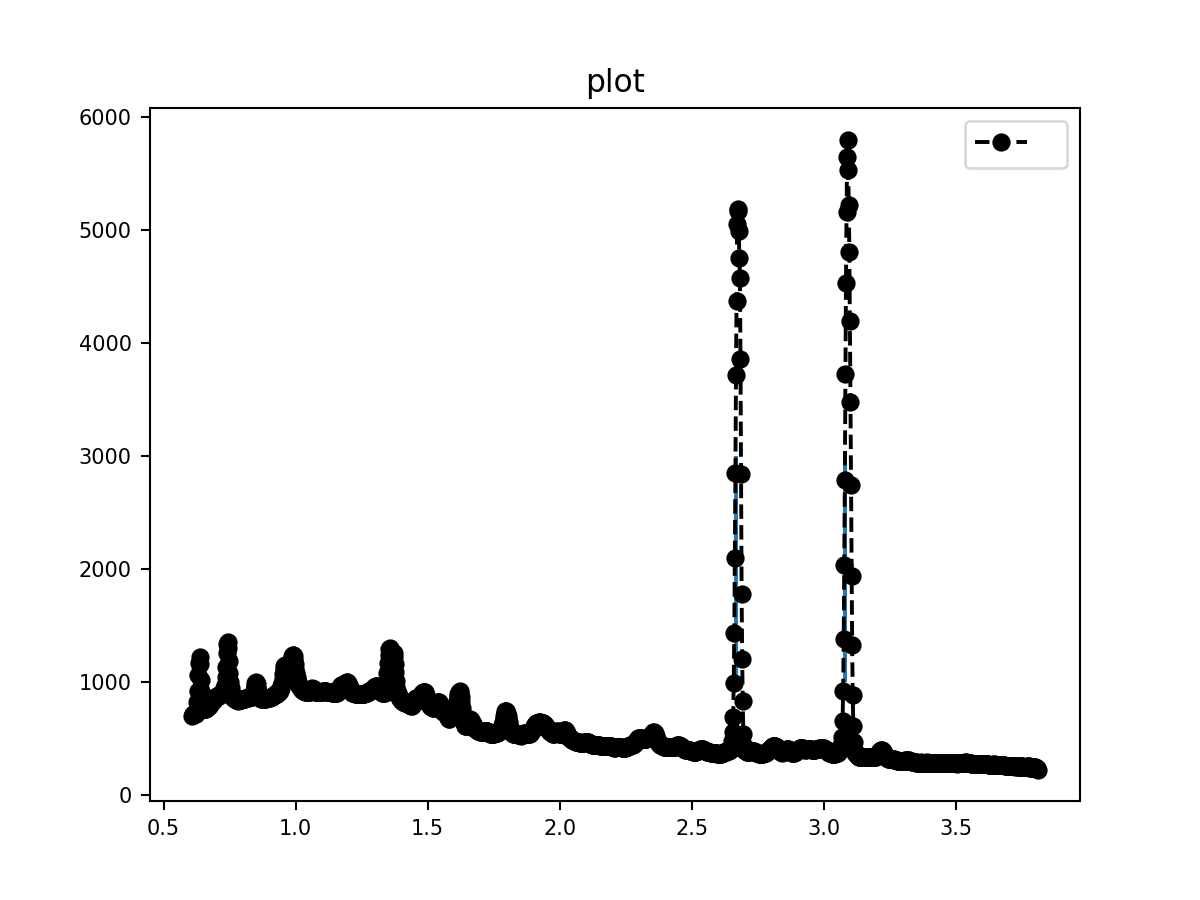

In [19]:
fig, ax = plt.subplots()
plot1D( x=q_ca, y=iq_ca, m='o', ls='--', c='k', ax=ax, )#xlim=[2.5, 3.2]) 
ax.vlines( p111, 1e3, 3e3 )
ax.vlines( p200, 1e3, 3e3 )
# ax.vlines( p100 * 6, .1e3, 3e3 )
# ax.vlines( p100 * 7, .1e3, 3e3 )
# ax.vlines( p100 * 8, .1e3, 3e3 )
# ax.vlines( p100 * 9, .1e3, 3e3 )
# ax.vlines( p100 * 10, .1e3, 3e3 )
# ax.vlines( p100 * 11, .1e3, 3e3 )
# ax.vlines( p100 * 12, .1e3, 3e3 )
# ax.vlines( p100 * 13, .1e3, 3e3 )

# ax.vlines( 0.734, 100,400 )
# ax.vlines( 0.9, 100,400 )
# ax.vlines( 1.04, 100,400 )
# ax.vlines( 1.16, 100,400 )
# ax.vlines( 1.27, 100,400 )

#ax.set_xlim([0.6,1.5])
#ax.set_ylim(600,1500)

## Using AI to refine the beam center if necessary

###  First to check the qphi plot to find the roi-q/phi

In [20]:
Img = img #(img * ~maskw).copy()
qphi_bins = [ 1000, 180 ];Prange=None;Qrange=None
q_QP, phi_QP, qphi_QP = SC.img_to_qphi(img=Img,Qrange=Qrange,Prange=Prange, bins=qphi_bins,method='ai',
                                       mask=maskw)
q_QPq,  iq_QPq = SC.qphi_to_iq( qphi_QP, q_range=q_QP, p_range=phi_QP, )
p_QPp,  ip_QPp = SC.qphi_to_ip( qphi_QP, q_range=q_QP, p_range=phi_QP, Qrange=None ) 
             

    

/home/group/Software/pyScatt/pyScatt/generic_functions.py:771: RuntimeWarning: invalid value encountered in true_divide
  return sums/cts


<IPython.core.display.Javascript object>


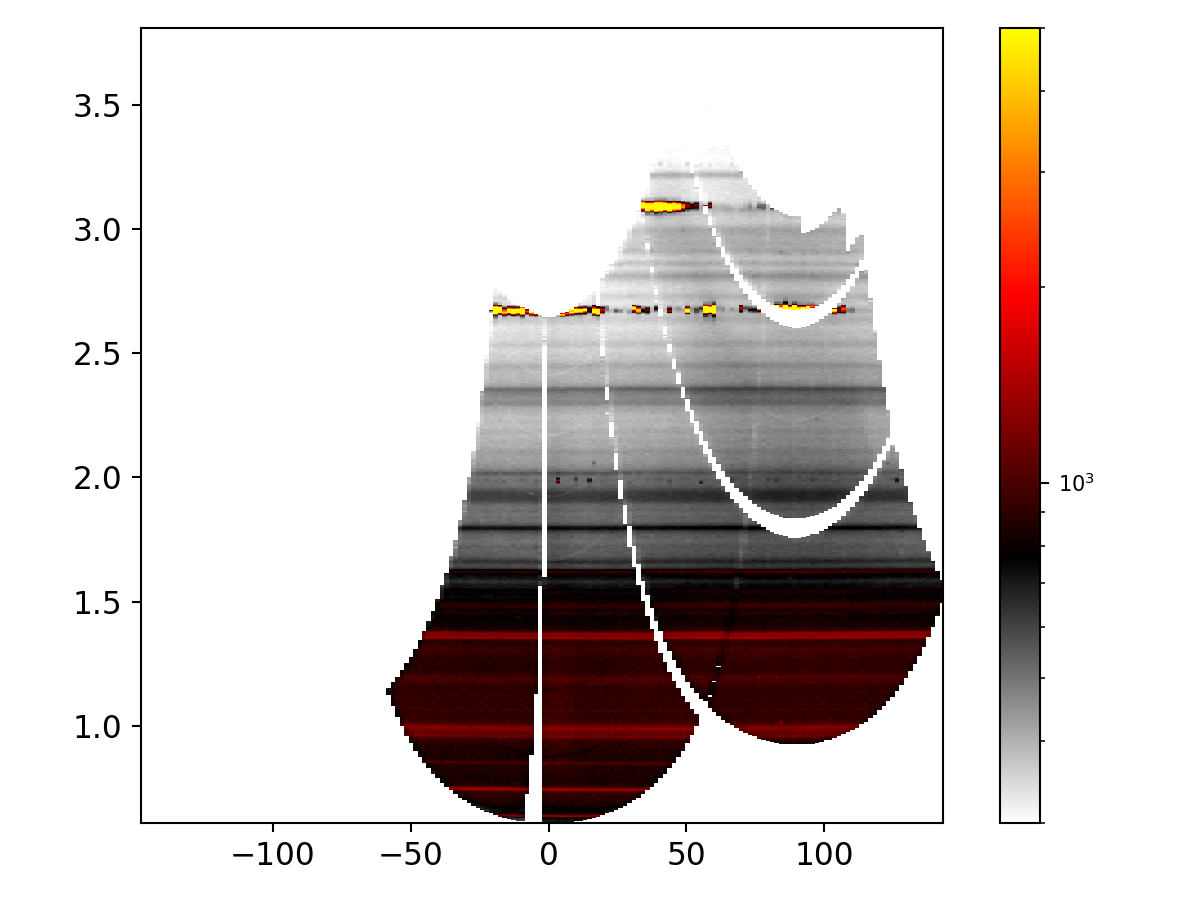

In [21]:
show_img( qphi_QP.T , logs=True, show_colorbar=True,  vmax=5e3, vmin=300, aspect=90,cmap=cmap_albula,
        extent=[  phi_QP[0], phi_QP[-1], q_QP[0], q_QP[-1] ]
        )

<IPython.core.display.Javascript object>


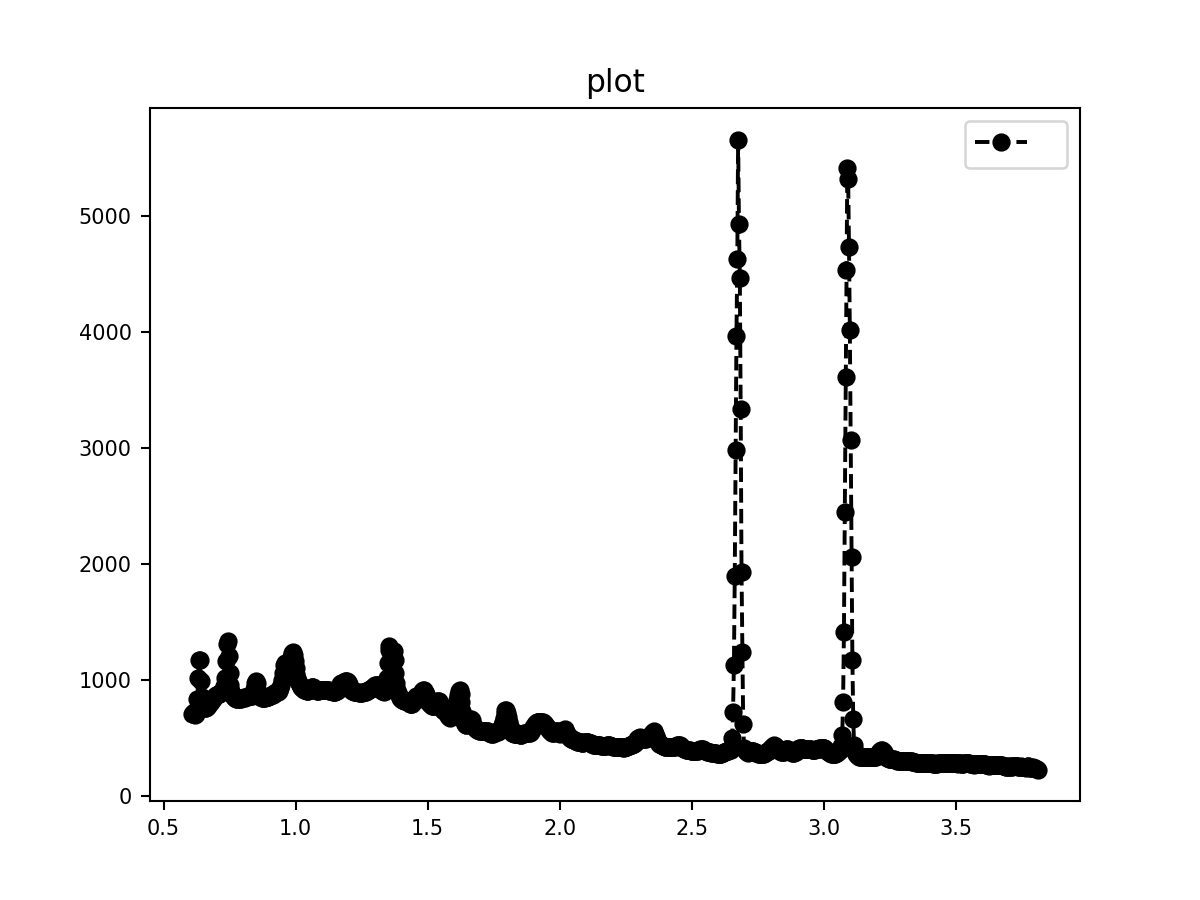

In [22]:
fig, ax = plt.subplots()
plot1D( x=q_QPq,  y=iq_QPq, m='o', ls='--', c='k', ax=ax, )#xlim=[2.5, 3.2]) 

In [23]:
# fig, ax = plt.subplots()
# plot1D( x=p_QPp,  y=  ip_QPp, m='o', ls='--', c='k', ax=ax, )#xlim=[2.5, 3.2]) 

In [24]:
qphi_bins = [ 200, 140 ];Prange=[ -35, 135] ;Qrange=[ 1.623 - .03, 1.623 + .03    ];      
q_QP, phi_QP, qphi_QP = SC.img_to_qphi(img=Img,Qrange=Qrange,Prange=Prange, bins=qphi_bins,method='ai',mask=maskw)
q_QPq,  iq_QPq = SC.qphi_to_iq( qphi_QP, q_range=q_QP, p_range=phi_QP, )
p_QPp,  ip_QPp = SC.qphi_to_ip( qphi_QP, q_range=q_QP, p_range=phi_QP, Qrange=None ) 
             


/home/group/Software/pyScatt/pyScatt/generic_functions.py:771: RuntimeWarning: invalid value encountered in true_divide
  return sums/cts


<IPython.core.display.Javascript object>


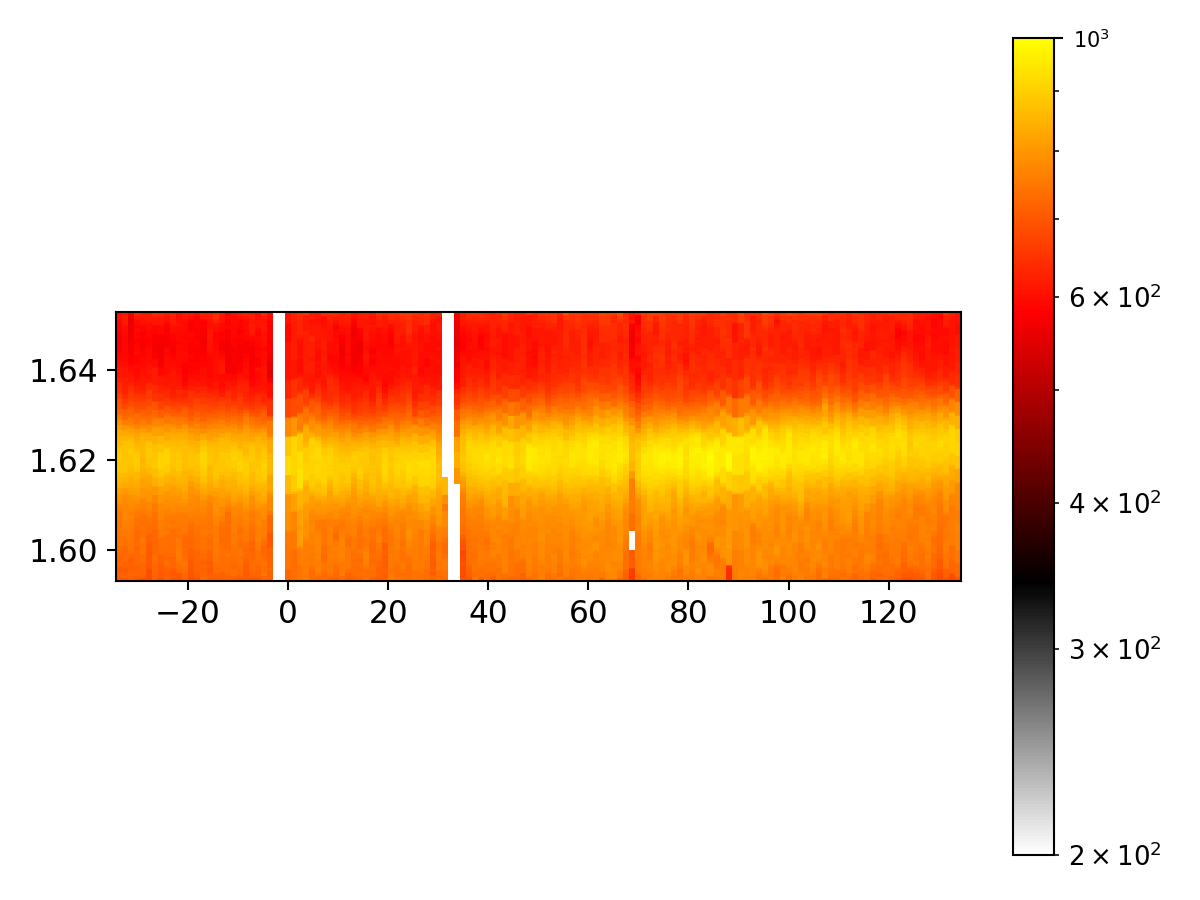

In [25]:
show_img( qphi_QP.T , logs=True, show_colorbar=True, vmax=1e3, vmin=200, aspect= 900,cmap=cmap_albula,
        extent=[  phi_QP[0], phi_QP[-1], q_QP[0], q_QP[-1] ] )


In [26]:
%run -i ~/Software/pyScatt/pyScatt/saxs.py

In [65]:
 
print(b_xy)

[756, 605]


In [28]:
res, bxym = search_beam_center_using_ai( Img, init_center=b_xy, SC=SC, mask=maskw, 
                               qphi_bins = qphi_bins, Prange=Prange , Qrange=Qrange,      
                                search_width = [2,2], search_step=[1,1,], show_plot=False,
                                       remove_hotspots=True, hotspots_std_scale=1.0,)

#print('The best beam center is: %s.'bxym)


0--bx=357,by=216,std=5.9
1--bx=357,by=217,std=5.1
2--bx=357,by=218,std=8.7
3--bx=357,by=219,std=11.3
4--bx=358,by=216,std=6.5
5--bx=358,by=217,std=3.4
6--bx=358,by=218,std=3.7
7--bx=358,by=219,std=7.0
8--bx=359,by=216,std=9.5
9--bx=359,by=217,std=6.3
10--bx=359,by=218,std=3.4
11--bx=359,by=219,std=4.1
12--bx=360,by=216,std=14.3
13--bx=360,by=217,std=10.6
14--bx=360,by=218,std=6.6
15--bx=360,by=219,std=4.9
The optimal beam center is: [359. 218.].


## Recalibrate the distance

In [29]:
username = 'Test'
beamline = 'CMS'
cycle='XX'
#geometry   =  'Reflection'
geometry   = 'Transmission'
wav_m = 1E-10 * (12.398/13.5)
sdd_mm =  260.8  #using Gold to do calibration
b_xy = [  359, 218  ]
bs_xy = [ 0.0, 0.0]   
incident_angle = 0
det_str = 'Pilatus800'
hotpixel_thres = 1e6  
pargs_sc = dict( wav_m = wav_m, 
                sdd_mm = sdd_mm, 
                b_xy =b_xy, 
                bs_xy = bs_xy, 
                incident_angle = incident_angle,             
                det_str = det_str, 
                bs_kind = None, 
                useqx = True,
                geometry =  geometry,                
                username = username, 
                cycle =  cycle, 
                beamline = beamline, 
                outDir = outDir, )
              # mask = mask )    
## Setup the class
SC = CMS_Scattering( pargs_sc  )

In [30]:
#fp = 'AgBH_cali_3m_13.5kev_x0.000_y0.000_5.00s_273001_waxs.tiff'
#fp = 'FL_Mar19_CB_313_202.6s_x0.400_y-0.000_10.00s_272994_waxs.tiff'
fp = 'FL_Mar19_ZMIM_246.4s_x0.400_y0.000_1.00s_272995_waxs.tiff'

img = get_cms_img( fp, inDir ) #[::-1]

In [31]:
Img = (img * ~maskw).copy()
q_ca,iq_ca = SC.img_circular_average(img= Img,Qrange=None,Prange=None,
                                                     bins=1500,method='ai',mask=maskw)




<IPython.core.display.Javascript object>


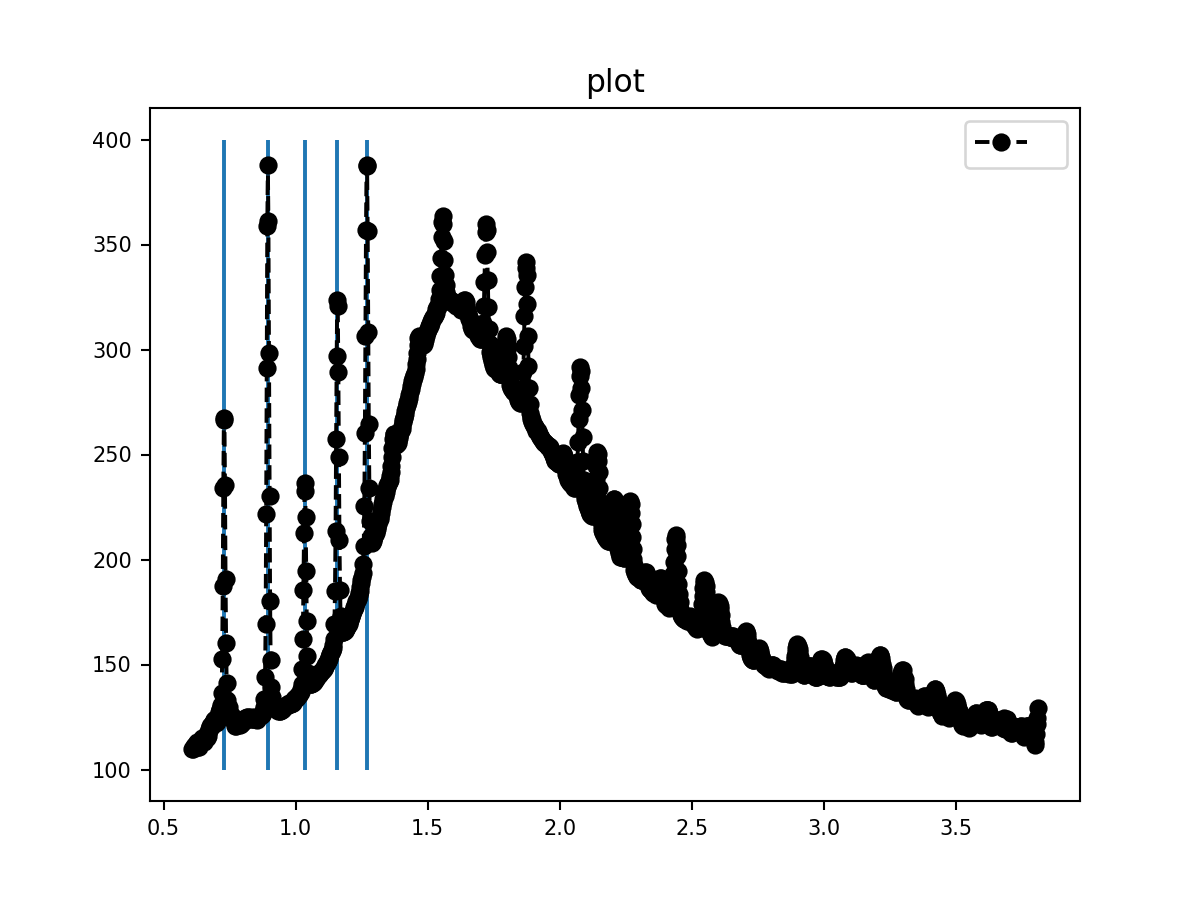

In [32]:
fig, ax = plt.subplots()
plot1D( x=q_ca, y=iq_ca, m='o', ls='--', c='k', ax=ax, )#xlim=[2.5, 3.2]) 
# ax.vlines( p111, 1e3, 3e3 )
# ax.vlines( p200, 1e3, 3e3 )

ax.vlines( 0.729, 100,400 )
ax.vlines( 0.895, 100,400 )
ax.vlines( 1.0355, 100,400 )
ax.vlines( 1.158, 100,400 )
ax.vlines( 1.27, 100,400 )

## Save the mask

In [33]:
#np.save(  outDir + 'mask_waxs_2021C1_YG', maskw  )



In [34]:
ls_dir( outDir), print( outDir)

/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/


(array(['mask_waxs_2021C1_YG.npy', 'mask_saxs_2021C1_YG.npy'], dtype='<U23'),
 None)

In [35]:
#m = np.load(  outDir + 'mask_waxs_2020C3_SWong.npy')

# SAXS

In [36]:
inDir = '/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/saxs/raw/'
outDir = '/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/'

create_fullpath(  outDir )

Directory  /home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/  already exists


'/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/'

In [37]:
fp = 'AgBH_cali_3m_13.5kev_x0.000_y0.000_5.00s_273001_saxs.tiff'
#fp = 'FL_Mar19_CB_313_202.6s_x0.400_y-0.000_10.00s_272994_waxs.tiff'
#fp = 'FL_Mar19_ZMIM_246.4s_x0.400_y0.000_1.00s_272995_waxs.tiff'

img = get_cms_img( fp, inDir ) #[::-1]
img.shape

(1679, 1475)

<IPython.core.display.Javascript object>


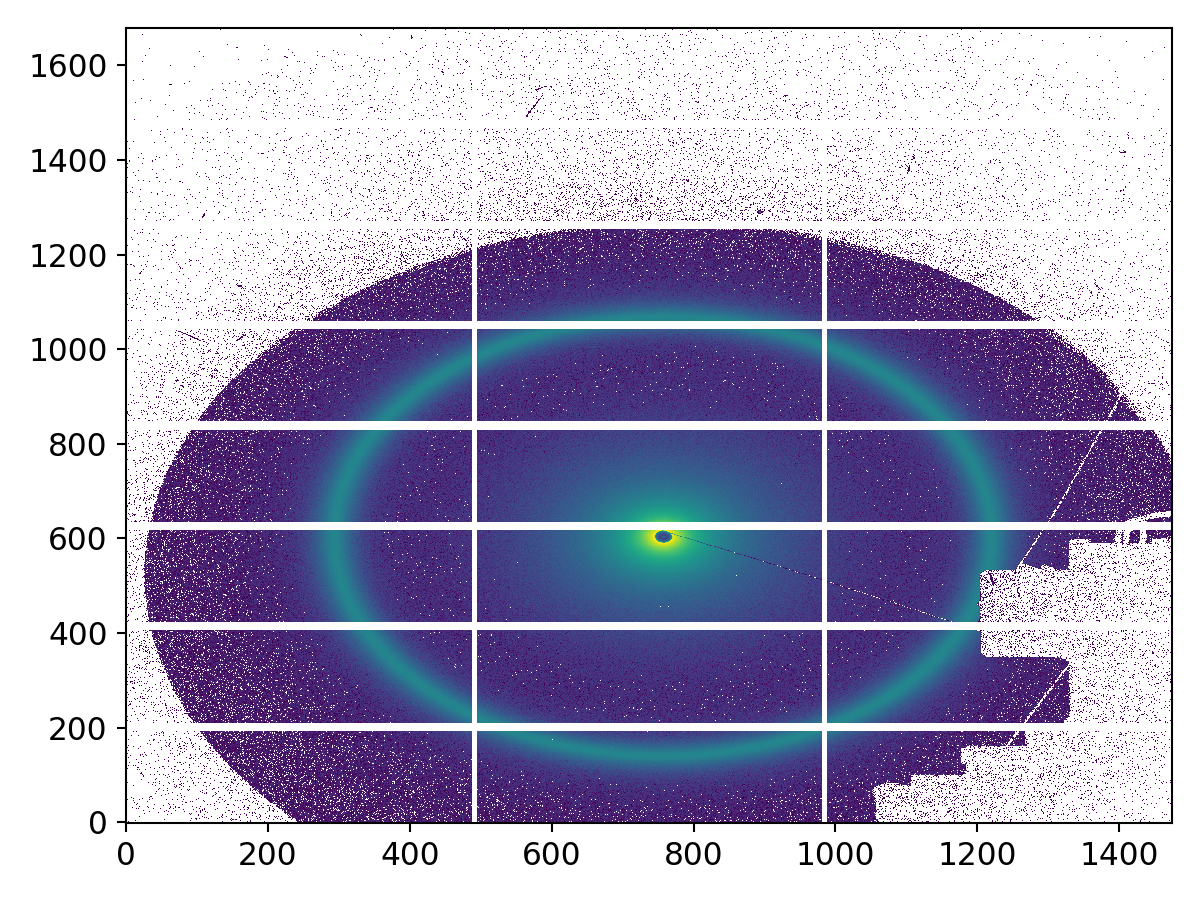

In [38]:
show_img( img , logs=True)

## get the chip mask

In [39]:
%run -i /home/yuzhang/Software/pyScatt/pyScatt/Detectors.py

In [40]:
img.shape

(1679, 1475)

In [41]:
det = get_detector( 'Pilatus2m' )
masks =  det.calc_mask()

<IPython.core.display.Javascript object>


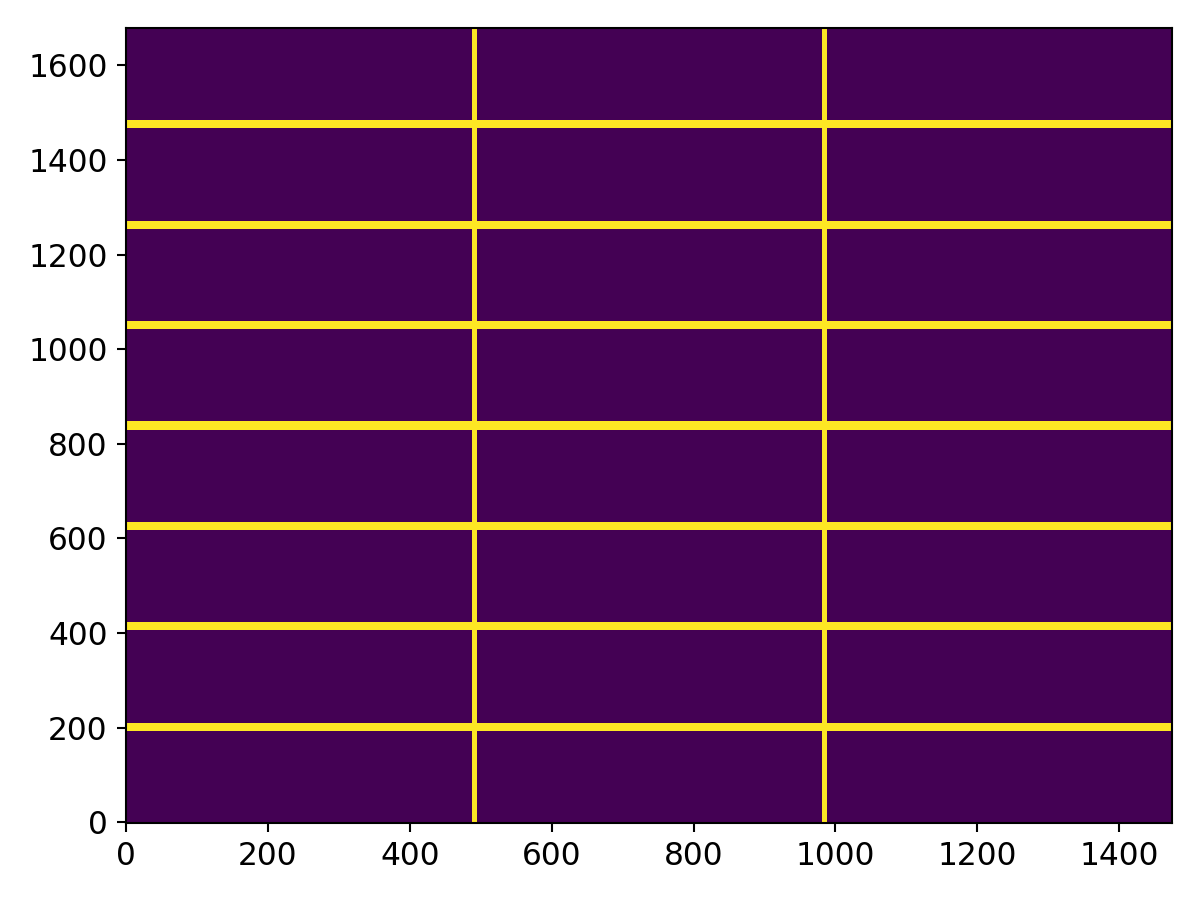

In [42]:
show_img( np.array( masks, dtype='int' )  )

<IPython.core.display.Javascript object>


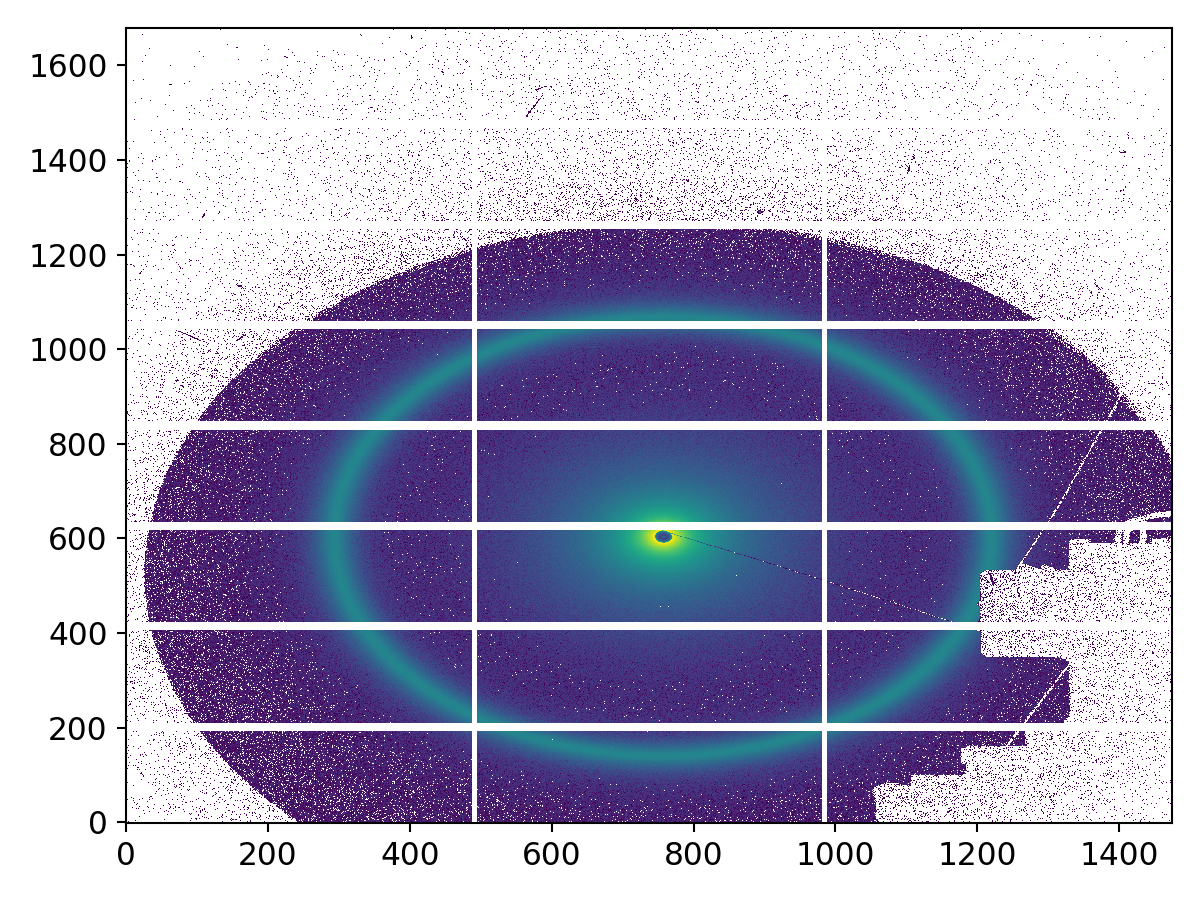

In [43]:
show_img( img  * ~masks , logs=True)

## create custom mask

In [44]:
cx,cy = [ 757, 1679 - 1075 ]
print( cx, cy )
#cx,cy = [754,  552 ]


757 604


In [45]:
cen_mask = create_cross_mask(   masks, center=[  cx,cy ],  
                                wy_left= 0, wy_right= 0, 
                                wx_up= 0, wx_down= 0, center_radius= 15 )
    
rot_mask = create_multi_rotated_rectangle_mask( masks,                                                   
                                                   center = [   770,610  ],                                                     
                                                   length=1500,
                                                   width= 5, 
                                                   angles=[  115 ] ) 

win_mask = ~ create_cross_mask(   masks, center=[  cx,cy ],  
                            wy_left= 0, wy_right= 0, 
                              wx_up= 0, wx_down= 0,center_radius=  720 )
    

masko = np.ones_like( masks, dtype=bool)
masko[   :110,  1050:,] = False
masko[   :166 ,  1070:,] = False
masko[   :200 ,  1258:,] = False
masko[   :360 ,  1320:,] = False
masko[  340 : 555 ,  1195:,] = False
masko[  530  : 610  ,  1320:,] = False
masko[  590:670  ,  1380:,] = False
masko[  :,486:494  ] = False
masko[  :,980:988  ] = False
rot_masko1 = create_multi_rotated_rectangle_mask( masks,
                                                   center = [    1240,166 ], 
                                                   length= 500,
                                                   width=  8, 
                                                   angles=[   27 ] ) 
rot_masko2 = create_multi_rotated_rectangle_mask( masks,
                                                   center = [    1260, 555 ], 
                                                   length= 500,
                                                   width=  8, 
                                                   angles=[   22.3 ] ) 

cen_maskN = ~create_cross_mask(   masks, center=[  cx,cy ],  
                                wy_left= 0, wy_right= 0, 
                                wx_up= 0, wx_down= 0, center_radius= 650 )

masko *= rot_masko1 * rot_masko2
masksc = cen_mask * rot_mask * win_mask * masko * cen_maskN
    
masksc = np.logical_not( masksc )
masks += masksc    

<IPython.core.display.Javascript object>


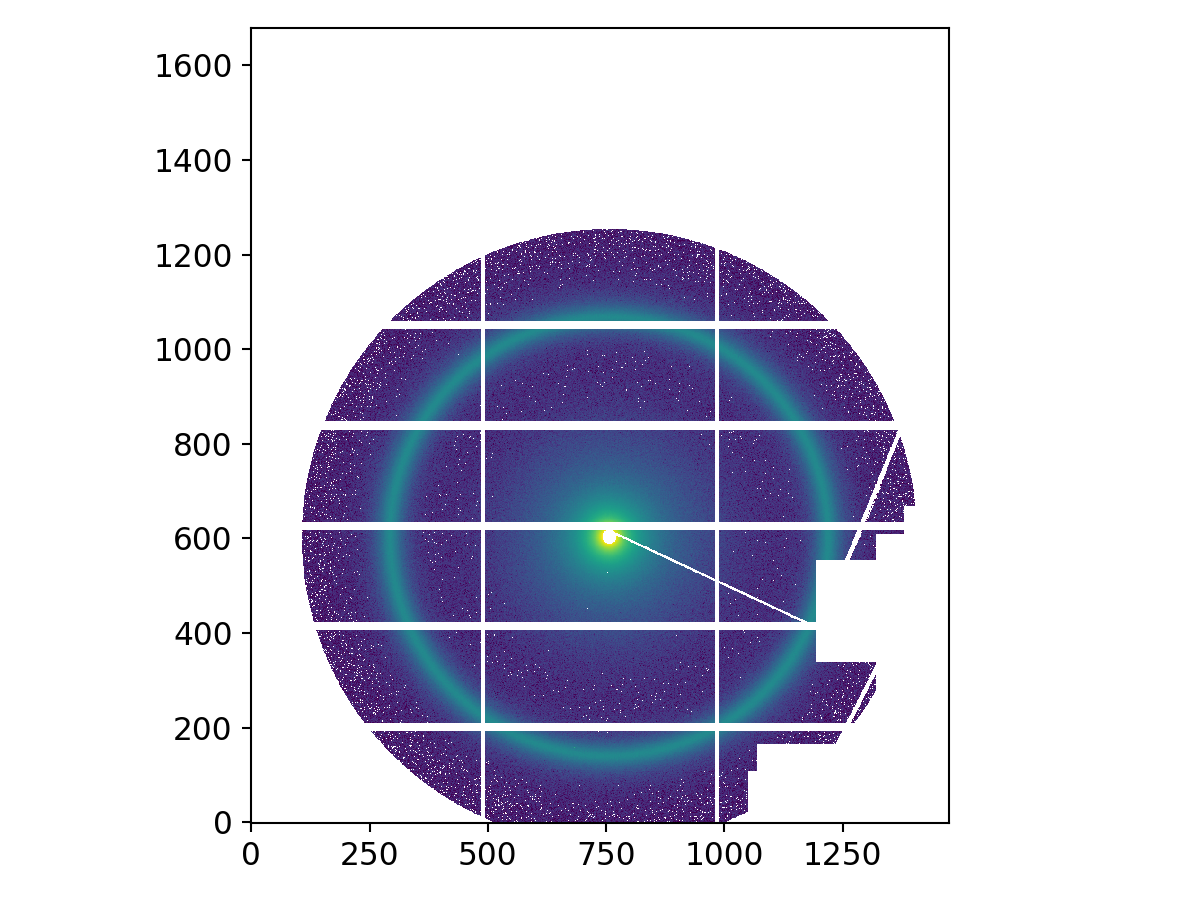

In [46]:
show_img(  img  *   ~masksc , logs=True, aspect=1)

<IPython.core.display.Javascript object>


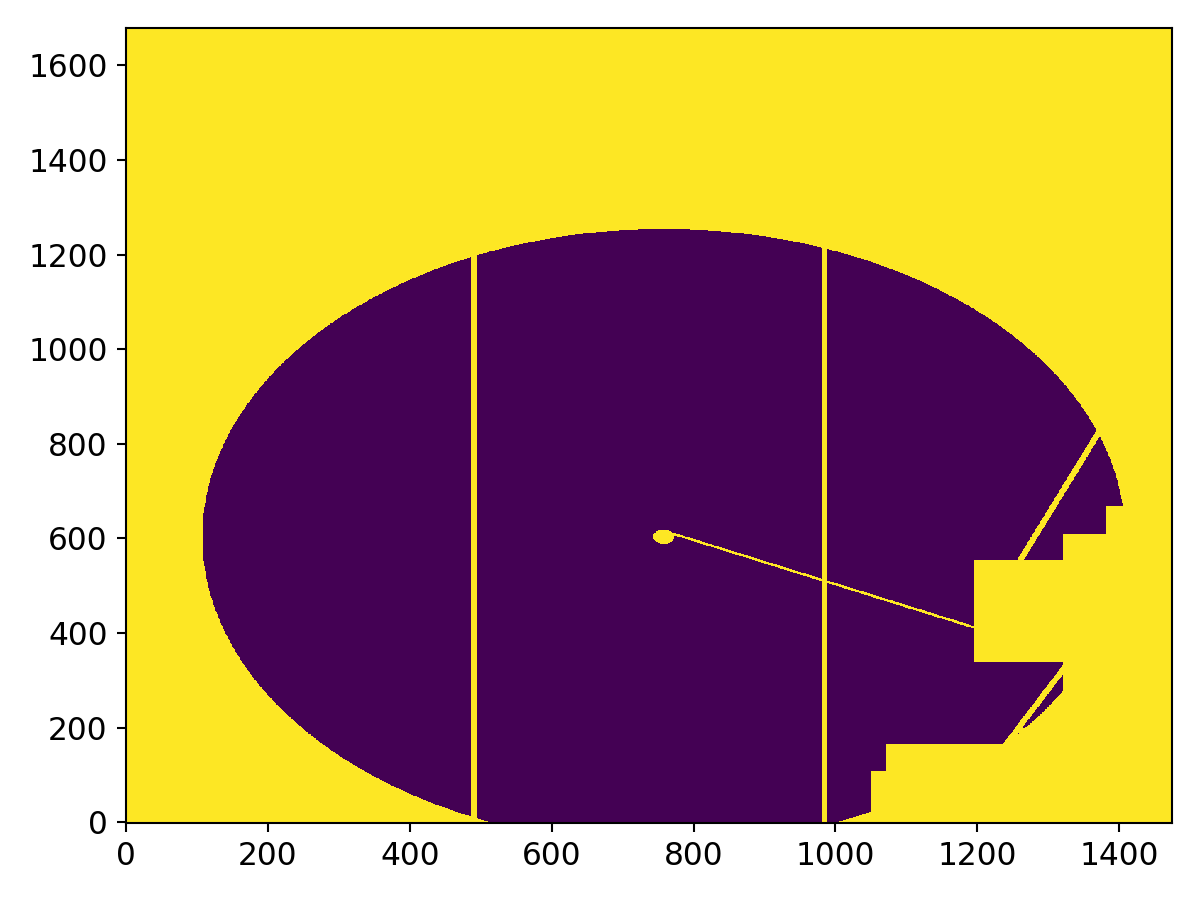

In [47]:
show_img(    masksc  )

## put all the mask together

<IPython.core.display.Javascript object>


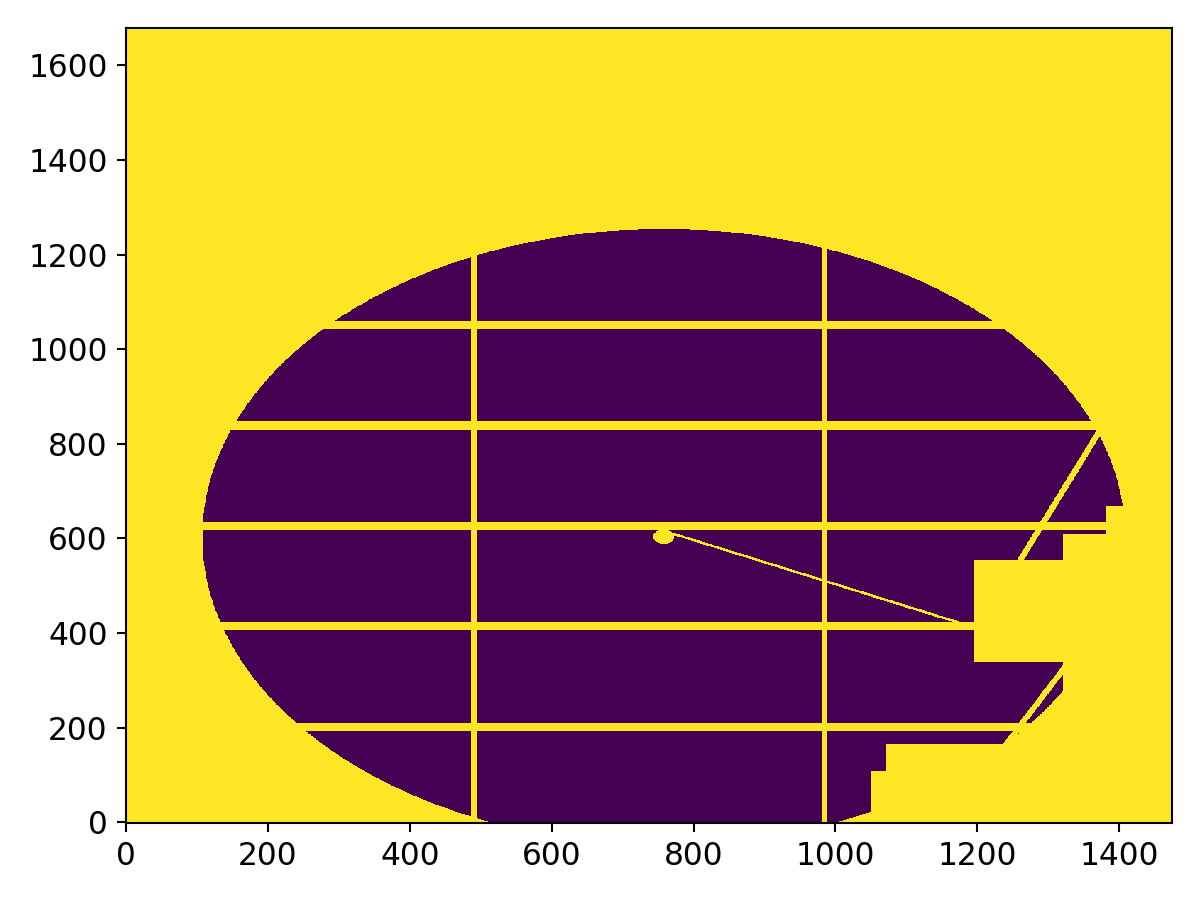

In [48]:
show_img( np.array( masks, dtype='int' )  )

In [49]:

#geometry   =  'Reflection'
geometry   = 'Transmission'
wav_m = 1E-10 * (12.398/  13.5 )
sdd_mm = 5060.0  
b_xy = [ 756, 605   ]
bs_xy = [ 0, 50]   
incident_angle = 0
det_str = 'Pilatus2m'
hotpixel_thres = 1e6  
pargs_sc = dict( wav_m = wav_m, 
                sdd_mm = sdd_mm, 
                b_xy =b_xy, 
                bs_xy = bs_xy, 
                incident_angle = incident_angle,             
                det_str = det_str, 
                bs_kind = None, 
                useqx = True,
                geometry =  geometry,                
                username = username, 
                cycle =  cycle, 
                beamline = beamline, 
                outDir = outDir, )
              # mask = mask )    
## Setup the class
SC = CMS_Scattering( pargs_sc  )

In [50]:
Img = img  *   ~masksc

In [51]:
q_ca,iq_ca = SC.img_circular_average(img= Img,Qrange=None,Prange=None,
                                                     bins=1500,method='ai',mask=masks)



<IPython.core.display.Javascript object>


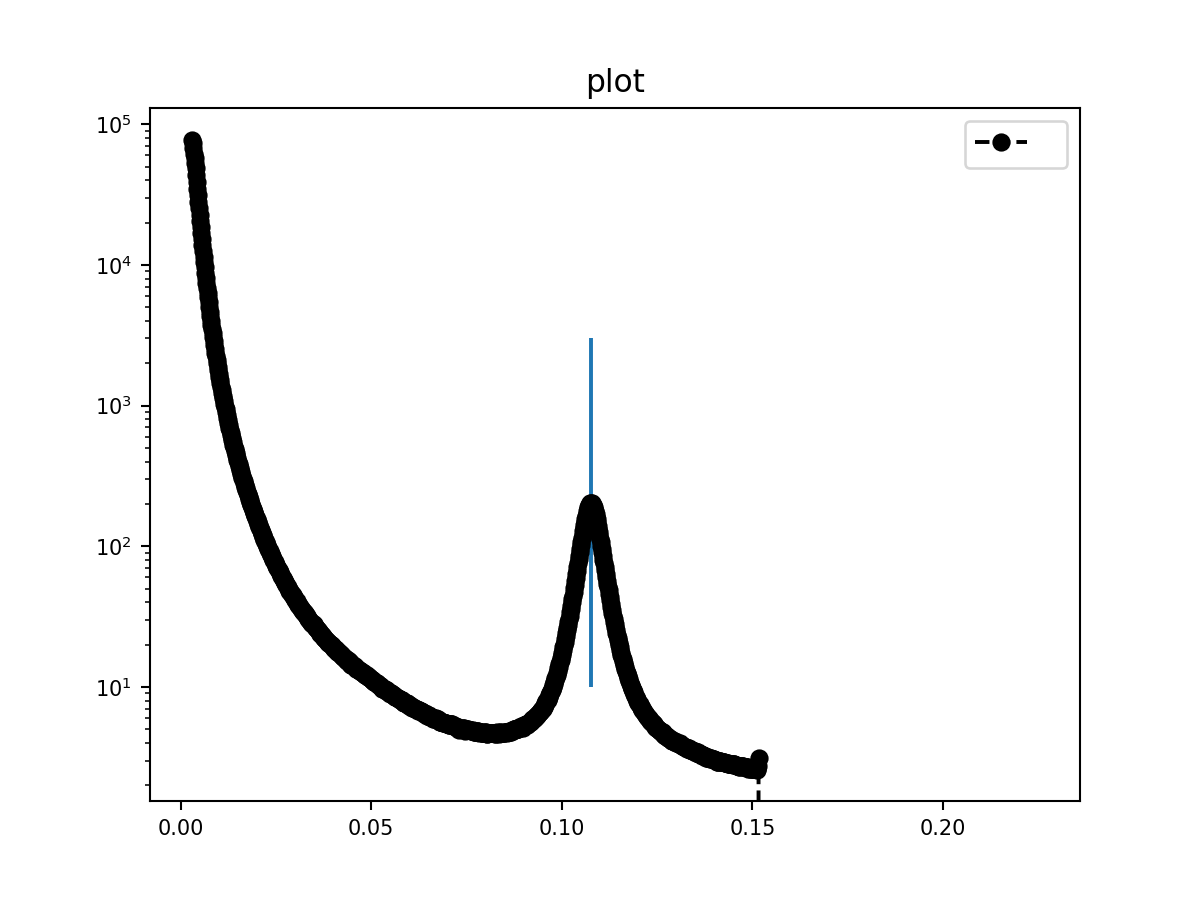

In [52]:
fig, ax = plt.subplots()
plot1D( x=q_ca, y=iq_ca, m='o', ls='--', c='k', ax=ax, logy=True )#xlim=[2.5, 3.2]) 
ax.vlines( p100, 1e1, 3e3 )

# Using AI refine beamcenter

/home/group/Software/pyScatt/pyScatt/generic_functions.py:771: RuntimeWarning: invalid value encountered in true_divide
  return sums/cts


<IPython.core.display.Javascript object>


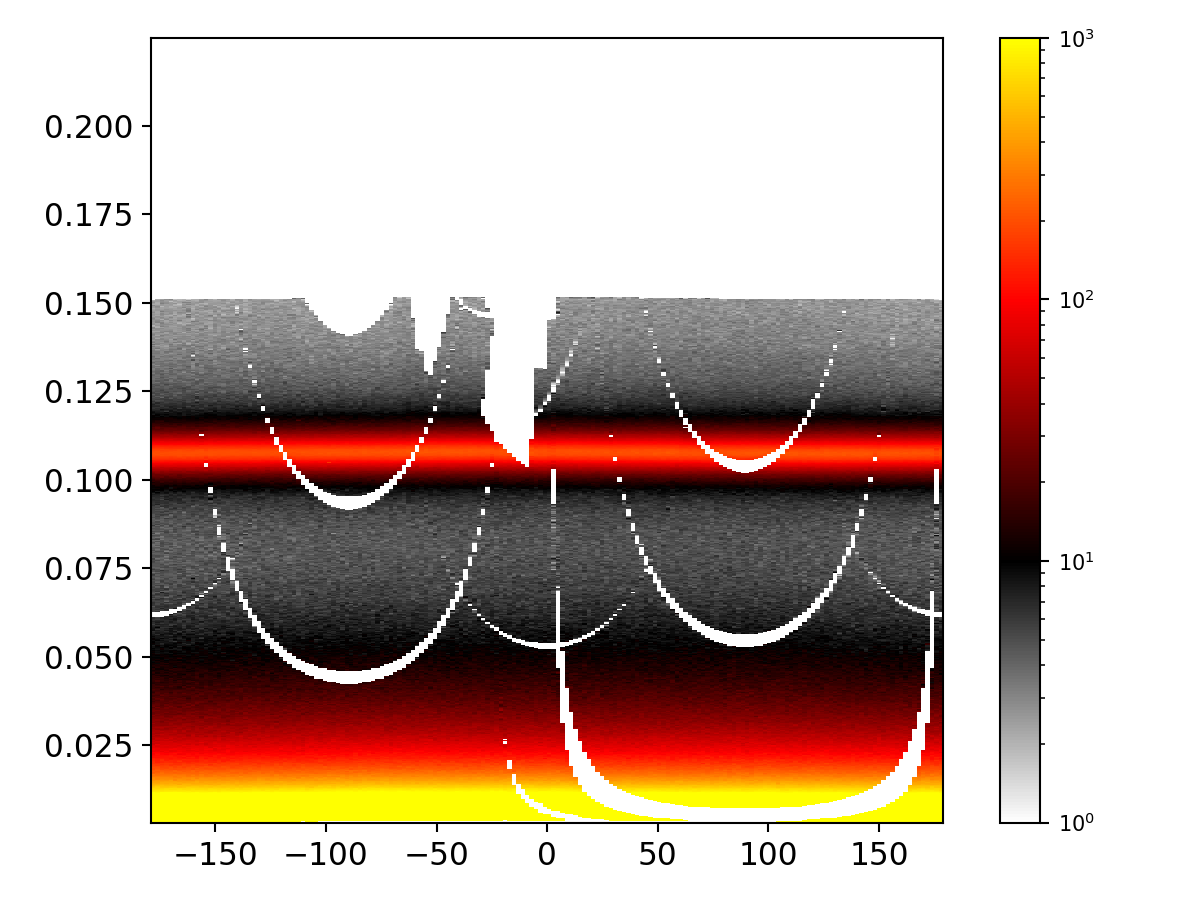

In [53]:
Img = img #(img * ~maskw).copy()
qphi_bins = [ 1000, 180 ];Prange=None;Qrange=None
q_QP, phi_QP, qphi_QP = SC.img_to_qphi(img=Img,Qrange=Qrange,Prange=Prange, bins=qphi_bins,method='ai',
                                       mask=masks)
q_QPq,  iq_QPq = SC.qphi_to_iq( qphi_QP, q_range=q_QP, p_range=phi_QP, )
p_QPp,  ip_QPp = SC.qphi_to_ip( qphi_QP, q_range=q_QP, p_range=phi_QP, Qrange=None ) 
             

show_img( qphi_QP.T , logs=True, show_colorbar=True,  vmax=1e3, vmin=1.0, aspect=1600,cmap=cmap_albula,
        extent=[  phi_QP[0], phi_QP[-1], q_QP[0], q_QP[-1] ]
        )

<IPython.core.display.Javascript object>


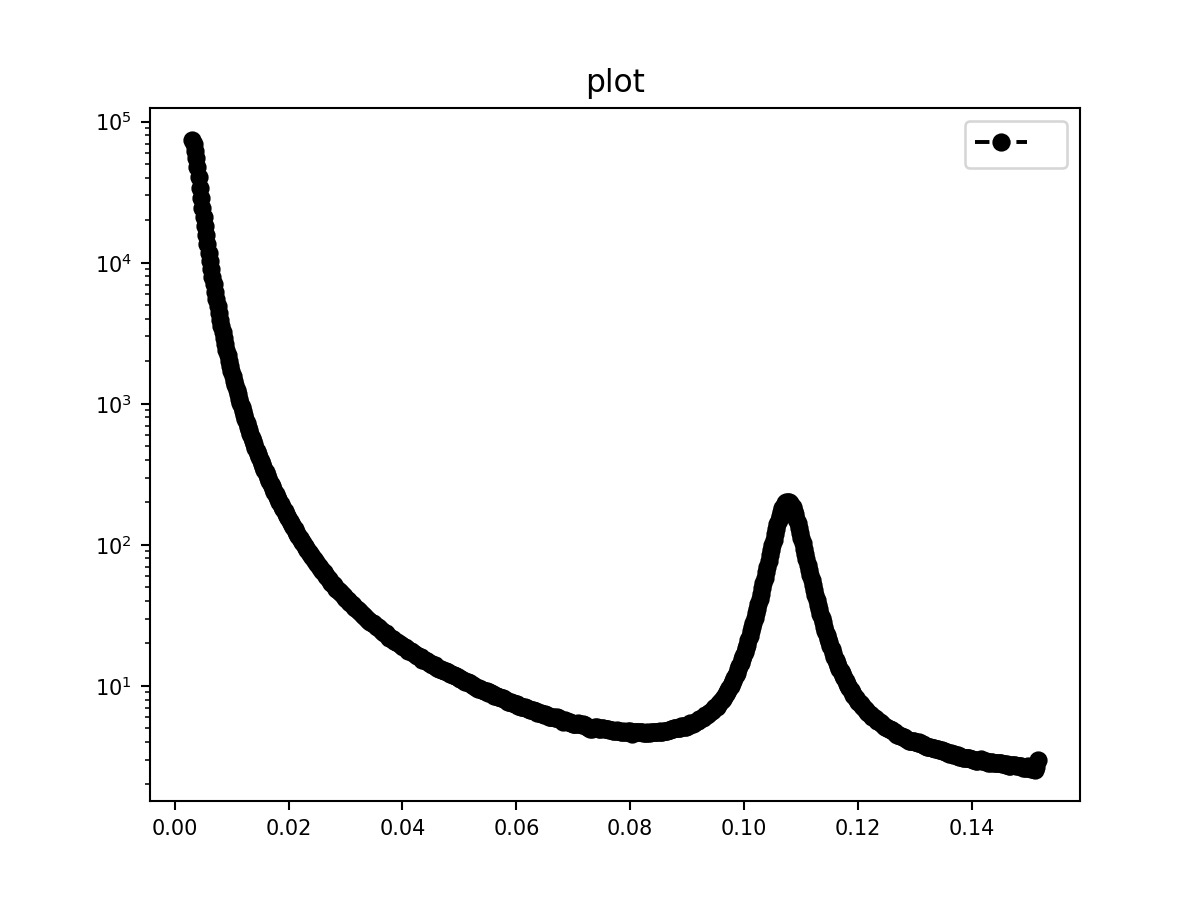

In [54]:
fig, ax = plt.subplots()
plot1D( x=q_QPq,  y=iq_QPq, m='o', ls='--', c='k', ax=ax, logy=True )#xlim=[2.5, 3.2]) 

<IPython.core.display.Javascript object>


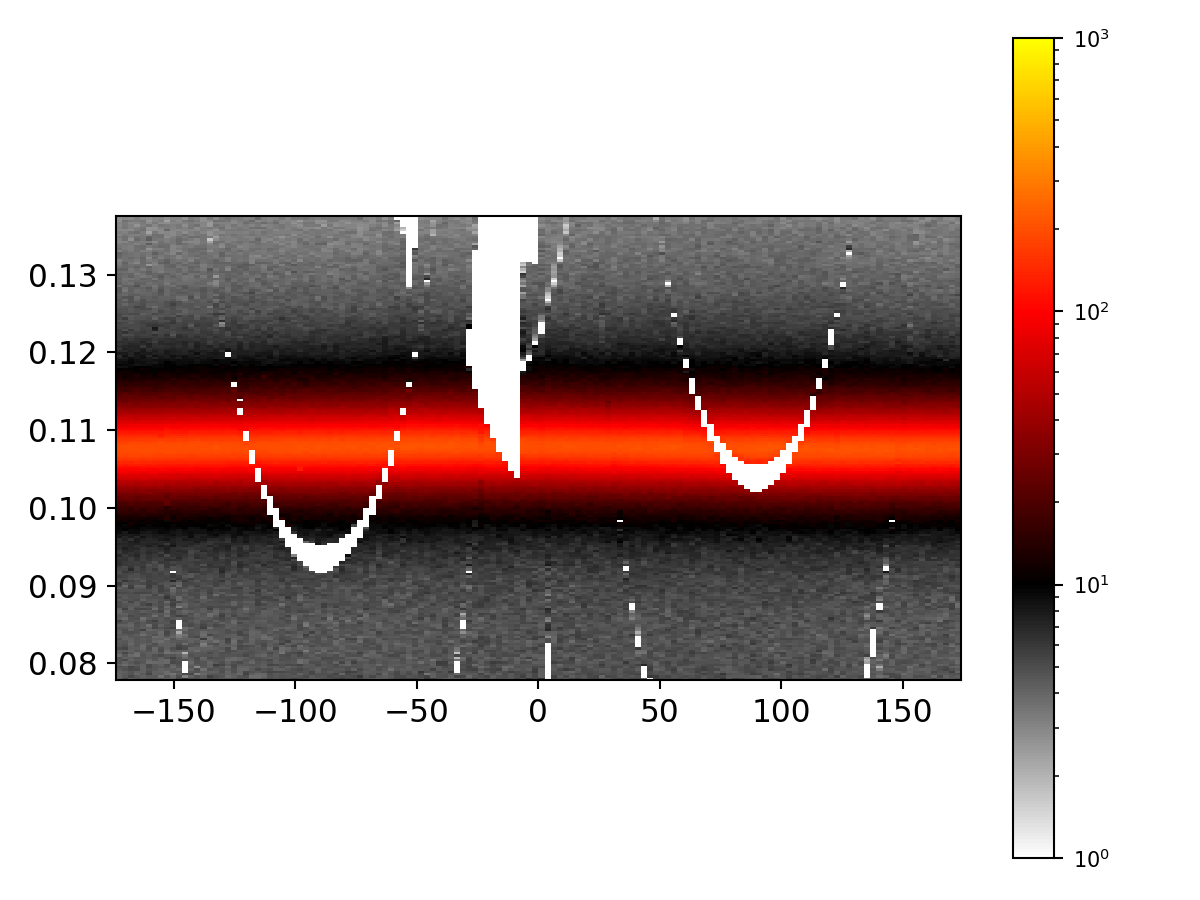

In [55]:
qphi_bins = [ 200, 140 ];Prange=[ -175, 175] ;Qrange=[ 0.1077 - .03, 0.1077 + .03    ];      
q_QP, phi_QP, qphi_QP = SC.img_to_qphi(img=Img,Qrange=Qrange,Prange=Prange, bins=qphi_bins,method='ai',mask=masks)
q_QPq,  iq_QPq = SC.qphi_to_iq( qphi_QP, q_range=q_QP, p_range=phi_QP, )
p_QPp,  ip_QPp = SC.qphi_to_ip( qphi_QP, q_range=q_QP, p_range=phi_QP, Qrange=None ) 
             

show_img( qphi_QP.T , logs=True, show_colorbar=True,  vmax=1e3, vmin=1.0, aspect=3200,cmap=cmap_albula,
        extent=[  phi_QP[0], phi_QP[-1], q_QP[0], q_QP[-1] ]
        )

In [56]:
print(b_xy)

[756, 605]


In [57]:
 res, bxym = search_beam_center_using_ai( Img, init_center= b_xy, SC=SC, mask=masks, 
                    qphi_bins = qphi_bins,Prange=Prange,Qrange=Qrange,     
                                search_width = [2,2], search_step=[1,1,], show_plot=False,
                                       remove_hotspots=False, hotspots_std_scale=1.0,)

0--bx=754,by=603,std=2.2
1--bx=754,by=604,std=2.1
2--bx=754,by=605,std=2.1
3--bx=754,by=606,std=2.2
4--bx=755,by=603,std=2.1
5--bx=755,by=604,std=2.0
6--bx=755,by=605,std=1.9
7--bx=755,by=606,std=2.0
8--bx=756,by=603,std=2.0
9--bx=756,by=604,std=1.9
10--bx=756,by=605,std=1.9
11--bx=756,by=606,std=2.0
12--bx=757,by=603,std=2.1
13--bx=757,by=604,std=1.9
14--bx=757,by=605,std=1.9
15--bx=757,by=606,std=2.0
The optimal beam center is: [756. 605.].


In [58]:

#geometry   =  'Reflection'
geometry   = 'Transmission'
wav_m = 1E-10 * (12.398/  13.5 )
sdd_mm = 5060.0  
b_xy = [ 756, 605   ]
bs_xy = [ 0, 50]   
incident_angle = 0
det_str = 'Pilatus2m'
hotpixel_thres = 1e6  
pargs_sc = dict( wav_m = wav_m, 
                sdd_mm = sdd_mm, 
                b_xy =b_xy, 
                bs_xy = bs_xy, 
                incident_angle = incident_angle,             
                det_str = det_str, 
                bs_kind = None, 
                useqx = True,
                geometry =  geometry,                
                username = username, 
                cycle =  cycle, 
                beamline = beamline, 
                outDir = outDir, )
              # mask = mask )    
## Setup the class
SC = CMS_Scattering( pargs_sc  )

In [59]:
fp = 'AgBH_cali_3m_13.5kev_x0.000_y0.000_5.00s_273001_saxs.tiff'
#fp = 'FL_Mar19_CB_313_202.6s_x0.400_y-0.000_10.00s_272994_waxs.tiff'
#fp = 'FL_Mar19_ZMIM_246.4s_x0.400_y0.000_1.00s_272995_waxs.tiff'

img = get_cms_img( fp, inDir ) #[::-1]
img.shape

(1679, 1475)

In [60]:
Img = (img * ~masks).copy()
q_ca,iq_ca = SC.img_circular_average(img= Img,Qrange=None,Prange=None,
                                                     bins=1500,method='ai',mask=masks)



0.10762509454695482


<IPython.core.display.Javascript object>


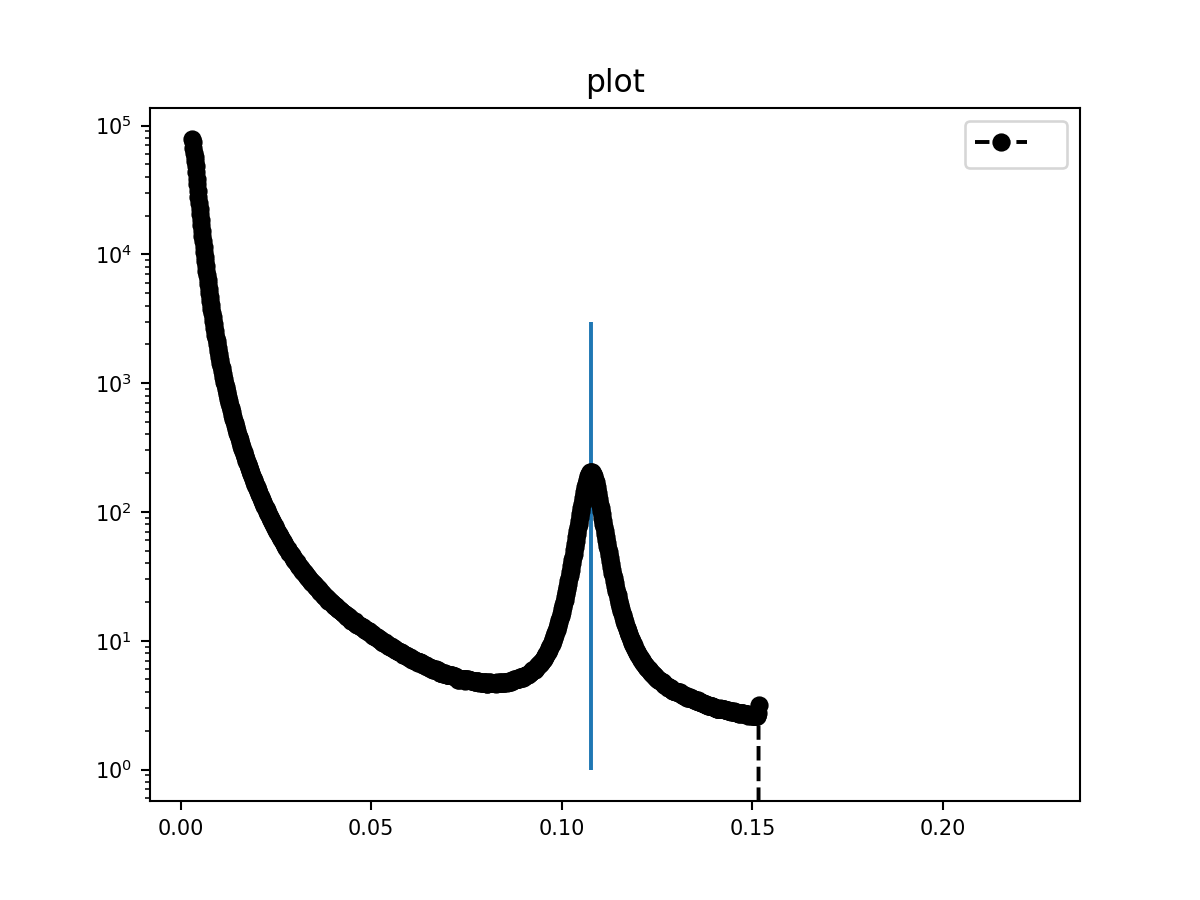

In [61]:
p100 = 2*np.pi/58.3803  #for AgBH 
print(p100)

fig, ax = plt.subplots()
plot1D( x=q_ca, y=iq_ca, m='o', ls='--', c='k', ax=ax, logy=True )#xlim=[2.5, 3.2]) 
ax.vlines( p100, 1 , 3e3 )



## Save the mask

In [62]:
outDir

'/home/yuzhang/NSLSII_Data_Link/CMS/2021_Cycle1/YZhang2/Mask/'

In [63]:
#np.save(  outDir + 'mask_saxs_2021C1_YG', masks  )

#np.save(  outDir + 'mask_saxs_2020C3_SWong', masks[::-1] )
#np.save(  outDir + 'mask_saxs_2020C3_SWong_noygap2', masksc[::-1] )
#np.save(  outDir + 'mask_saxs_2020C3_SWong_noygap3', masksc[::-1] )






In [64]:
#m=np.load( outDir + 'mask_saxs_2020C3_SWong.npy')
#show_img(m)

# The End